### 测试稀疏矩阵运算 $\Leftarrow$ `SparseTensor, spspmm`

In [1]:
import torch
import numpy as np
from torch_sparse import SparseTensor, spspmm
import pickle


/home/lihao/hdd/anaconda3/envs/sognn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
edge_index = pickle.load(open('./edge_index.pkl', 'rb'))
nodes = torch.max(edge_index).item() + 1
sp1 = SparseTensor.from_edge_index(edge_index, sparse_sizes=(nodes, nodes))
print(sp1)
vl1 = torch.ones((edge_index.shape[1])).cuda()
np.random.seed(1)
eix = edge_index.clone()
val = vl1.clone()
for _ in range(4):
    eix, val = spspmm(eix, val, edge_index, vl1, nodes, nodes, nodes)
print(val.dtype)

SparseTensor(row=tensor([    0,     0,     0,  ..., 19714, 19715, 19716], device='cuda:0'),
             col=tensor([ 1378,  1544,  6092,  ..., 12278,  4284, 16030], device='cuda:0'),
             size=(19717, 19717), nnz=88649, density=0.02%)
torch.float32


In [3]:

ei = eix[0]
ei_ = torch.cat([ei[0:1], ei[:-1]])

cutpoints = torch.nonzero(ei - ei_).squeeze().tolist()
cutpoints = [0] + cutpoints + [ei.shape[0]]
len(cutpoints)

19718

In [4]:
adj_raw = [(eix[:, start:end], val[start:end]) for start, end in zip(cutpoints[:-1], cutpoints[1:])]
a = 0
for (data, val) in adj_raw:
    a = max(len(val), a)
a

17951

In [75]:
mean_value = [torch.mean(value) / 1. for data, value in adj_raw]
adj_selected_raw = [data[:, value<mean] for (data, value), mean in zip(adj_raw, mean_value)]
adj_selected = torch.cat(adj_selected_raw, dim=-1)

In [77]:
SparseTensor.from_edge_index(adj_selected, sparse_sizes=(nodes, nodes))

SparseTensor(row=tensor([0, 0]),
             col=tensor([1, 2]),
             size=(4, 4), nnz=2, density=12.50%)

In [12]:
a = torch.tensor([1, 3, 14, 2, 2, 15, 444, 31, 2])
b = torch.tensor([[1, 3, 14, 2, 2, 15, 444, 31, 2],[1, 3, 14, 2, 2, 15, 444, 31, 2]])
_, index = torch.topk(a, 5, largest=False)
print(index)
index = torch.sort(index).values
b[:,index]

tensor([0, 4, 8, 3, 1])


tensor([[1, 3, 2, 2, 2],
        [1, 3, 2, 2, 2]])

In [ ]:
import torch
edge_index = torch.tensor([[0, 0, 1, 2, 3, 4],[1, 2, 4, 3, 0, 0]])
value = torch.tensor([0, 0, 1, 2, 3, 4])
ei = edge_index[0]
ei_ = torch.cat([ei[0:1], ei[:-1]])

cutpoints = torch.nonzero(ei - ei_).squeeze().tolist()
cutpoints = [0] + cutpoints + [ei.shape[0]]

# 2. 切分spt
adj_raw = [(edge_index[:, start:end], value[start:end]) 
            for start, end in zip(cutpoints[:-1], cutpoints[1:])]
for (data, value) in adj_raw:
    print(len(data[0]), len(value))
    print(data, value)

### 测试plot_influence $\Leftarrow$ `torch.autograd`

In [3]:
import torch
from torch_sparse import SparseTensor
from models.sognn import NodeLevelSOGNN
from models.sognn_layer import SOGNNConv
from models.gcn import NodeLevelGCN

from models.utils import get_jacobian
from torch_geometric.data import Data

/home/lihao/hdd/anaconda3/envs/sognn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
edge_index = torch.LongTensor([
    [0, 1, 2, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 7, 7, 8, 8, 9],
    [3, 3, 3, 0, 1, 2, 5, 5, 3, 4, 6, 7, 5, 5, 8, 7, 9, 8]
])
print(len(str(edge_index[0][1].item())))
# value = torch.ones((edge_index.shape[1]))
# x = torch.rand((10, 20), requires_grad=True)
# data = Data(x, edge_index, value)
# # y = x.clone()
# adj_m = SparseTensor.from_edge_index(edge_index,sparse_sizes=(10, 10)).to_dense(dtype=torch.long)
# adj_m_d = torch.matmul(adj_m, adj_m)
# adj_m_d = torch.matmul(adj_m_d, adj_m)
# adj_m_d_s = SparseTensor.from_dense(adj_m_d).cuda()
# SOGNNConv.edge_index_distant = adj_m_d_s
# sognn = NodeLevelSOGNN(20, 3, 10, 0, 0.5, 0.001, 0.01)
# gcn = NodeLevelGCN(20, 3, 10, 0, 0.5, 0.001, 0.01)
# for r in range(8):
#     print(get_jacobian(sognn, data, 0, r))
#     print(get_jacobian(gcn, data, 0, r))


3


In [2]:
a = [1, 3, 4]
print(a.remove(3))

None


### 测试数据集

In [11]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch

In [12]:
pubmed = Planetoid('../data/pubmed/', 'pubmed')
data = DataLoader(pubmed, 4, shuffle=True)

In [13]:
dir(data)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'exclude_keys',
 'follow_batch',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout

### Networkx画图

2.2252525252525253
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Edges: [(0, 11), (0, 40), (0, 91), (0, 86), (0, 66), (0, 56), (0, 1), (0, 26), (1, 2), (1, 3), (1, 99), (1, 15), (1, 36), (1, 40), (1, 60), (1, 14), (1, 77), (1, 18), (2, 4), (2, 86), (2, 27), (2, 33), (2, 39), (2, 84), (2, 79), (2, 29), (2, 44), (2, 97), (2, 24), (2, 74), (3, 5), (3, 13), (3, 32), (3, 10), (3, 65), (3, 64), (3, 76), (3, 49), (3, 73), (3, 50), (4, 5), (4, 6), (4, 84), (4, 80), (4, 21), (4, 83), (5, 6), (5, 7), (5, 57), (5, 76), (5, 42), (5, 62), (5, 94), (5, 40), (5, 29), (6, 7), (6, 26), (6, 72), (6, 92), (6, 40), (6, 13), (6, 29), (6, 90), (6, 78), (7, 8), (

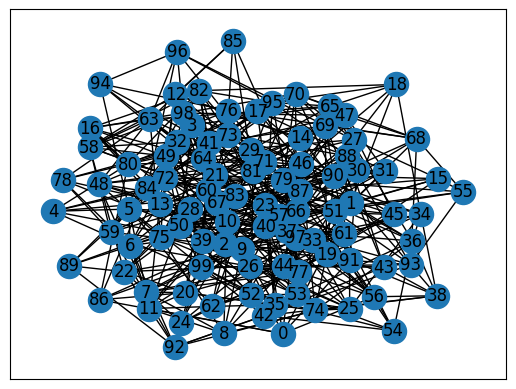

In [4]:
import networkx as nx
import random

# 定义参数
n_nodes = 100
n_edges = 500
average_distance = 10

# 构建图
G = nx.watts_strogatz_graph(n=n_nodes, k=4, p=0.5)
while len(G.edges()) < n_edges:
    nodes_list = list(nx.nodes(G))
    node1, node2 = random.sample(nodes_list, 2)
    G.add_edge(node1, node2)

# 计算平均距离
d = nx.average_shortest_path_length(G)
print(d)

# 绘制图形
nx.draw_networkx(G, with_labels=True)

# 输出节点和边的信息
print("Nodes:", G.nodes())
print("Edges:", G.edges())


In [5]:
nx.average_shortest_path_length(G)

2.2244444444444444